# 2D Cylinder Flow

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_notebook_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/physics_driven/mindspore_navier_stokes2D.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_download_code_en.svg)](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/r2.5.0/mindflow/en/physics_driven/mindspore_navier_stokes2D.py)&emsp;[![View Source On Gitee](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/r2.5.0/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/r2.5.0/docs/mindflow/docs/source_en/physics_driven/navier_stokes2D.ipynb)

This notebook requires **MindSpore version >= 2.0.0** to support new APIs including: *mindspore.jit, mindspore.jit_class, mindspore.jacrev*.

## Overview

Flow past cylinder problem is a two-dimensional low velocity steady flow around a cylinder which is only related to the `Re` number. When `Re` is less than or equal to 1, the inertial force in the flow field is secondary to the viscous force, the streamlines in the upstream and downstream directions of the cylinder are symmetrical, and the drag coefficient is approximately inversely proportional to `Re` . The flow around this `Re` number range is called the Stokes zone; With the increase of `Re` , the streamlines in the upstream and downstream of the cylinder gradually lose symmetry. This special phenomenon reflects the peculiar nature of the interaction between the fluid and the surface of the body. Solving flow past a cylinder is a classical problem in hydromechanics.

Since it is difficult to obtain the generalized theoretical solution of the Navier-Stokes equation,the numerical method is used to solve the governing equation in the flow past cylinder scenario to predict the flow field, which is also a classical problem in computational fluid mechanics. Traditional solutions often require fine discretization of the fluid to capture the phenomena that need to be modeled. Therefore, traditional finite element method (FEM) and finite difference method (FDM) are often costly.

Physics-informed Neural Networks (PINNs) provides a new method for quickly solving complex fluid problems by using loss functions that approximate governing equations coupled with simple network configurations. In this case, the data-driven characteristic of neural network is used along with `PINNs` to solve the flow past cylinder problem.

## Problem Description

The Navier-Stokes equation, referred to as `N-S` equation, is a classical partial differential equation in the field of fluid mechanics. In the case of viscous incompressibility, the dimensionless `N-S` equation has the following form:

$$
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0
$$

$$
\frac{\partial u} {\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} = - \frac{\partial p}{\partial x} + \frac{1} {Re} (\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2})
$$

$$
\frac{\partial v} {\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} = - \frac{\partial p}{\partial y} + \frac{1} {Re} (\frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2})
$$

where `Re` stands for Reynolds number.

In this case, the PINNs method is used to learn the mapping from the location and time to flow field quantities to solve the `N-S` equation.

$$
(x, y, t) \mapsto (u, v, p)
$$

## Technology Path

MindSpore Flow solves the problem as follows:

1. Training Dataset Construction.
2. Model Construction.
3. Multi-task Learning for Adaptive Losses
4. Optimizer.
5. NavierStokes2D.
6. Model Training.
7. Model Evaluation and Visualization.

In [1]:
import time

import numpy as np

import mindspore
from mindspore import nn, ops, Tensor, jit, set_seed, load_checkpoint, load_param_into_net
from mindspore import dtype as mstype


The following `src` pacakage can be downloaded in [applications/physics_driven/navier_stokes/cylinder_flow_forward/src](https://gitee.com/mindspore/mindscience/tree/r0.7/MindFlow/applications/physics_driven/navier_stokes/cylinder_flow_forward/src).

In [2]:
from mindflow.cell import MultiScaleFCCell
from mindflow.loss import MTLWeightedLossCell
from mindflow.pde import NavierStokes, sympy_to_mindspore
from mindflow.utils import load_yaml_config

from src import create_training_dataset, create_test_dataset, calculate_l2_error


set_seed(123456)
np.random.seed(123456)

In [3]:
# set context for training: using graph mode for high performance training with GPU acceleration
config = load_yaml_config('cylinder_flow.yaml')
mindspore.set_context(mode=mindspore.GRAPH_MODE, device_target="GPU", device_id=3)
use_ascend = mindspore.get_context(attr_key='device_target') == "Ascend"

## Training Dataset Construction

In this case, the initial condition and boundary condition data of the existing flow around a cylinder with Reynolds number 100 are sampled. For the training dataset, the problem domain and time dimension of planar rectangle are constructed. Then the known initial conditions and boundary conditions are sampled. The test dataset is constructed based on the existing points in the flow field.

Download the training and test dataset: [physics_driven/flow_past_cylinder/dataset](https://download.mindspore.cn/mindscience/mindflow/dataset/applications/physics_driven/flow_past_cylinder/dataset/).


In [4]:
# create training dataset
cylinder_flow_train_dataset = create_training_dataset(config)
cylinder_dataset = cylinder_flow_train_dataset.create_dataset(batch_size=config["train_batch_size"],
                                                              shuffle=True,
                                                              prebatched_data=True,
                                                              drop_remainder=True)

# create test dataset
inputs, label = create_test_dataset(config["test_data_path"])

./dataset
get dataset path: ./dataset
check eval dataset length: (36, 100, 50, 3)


## Model Construction

This example uses a simple fully-connected network with a depth of 6 layers and the activation function is the `tanh` function.

In [5]:
coord_min = np.array(config["geometry"]["coord_min"] + [config["geometry"]["time_min"]]).astype(np.float32)
coord_max = np.array(config["geometry"]["coord_max"] + [config["geometry"]["time_max"]]).astype(np.float32)
input_center = list(0.5 * (coord_max + coord_min))
input_scale = list(2.0 / (coord_max - coord_min))
model = MultiScaleFCCell(in_channels=config["model"]["in_channels"],
                         out_channels=config["model"]["out_channels"],
                         layers=config["model"]["layers"],
                         neurons=config["model"]["neurons"],
                         residual=config["model"]["residual"],
                         act='tanh',
                         num_scales=1,
                         input_scale=input_scale,
                         input_center=input_center)


## Multi-task learning for adaptive losses

The PINNs method needs to optimize multiple losses at the same time, and brings challenges to the optimization process. Here, we adopt the uncertainty weighting algorithm proposed in *Kendall, Alex, Yarin Gal, and Roberto Cipolla. "Multi-task learning using uncertainty to weigh losses for scene geometry and semantics." CVPR, 2018.* to dynamically adjust the weights.

In [6]:
mtl = MTLWeightedLossCell(num_losses=cylinder_flow_train_dataset.num_dataset)

## Optimizer

In [7]:
if config["load_ckpt"]:
    param_dict = load_checkpoint(config["load_ckpt_path"])
    load_param_into_net(model, param_dict)
    load_param_into_net(mtl, param_dict)

# define optimizer
params = model.trainable_params() + mtl.trainable_params()
optimizer = nn.Adam(params, config["optimizer"]["initial_lr"])

## NavierStokes2D

The following `NavierStokes2D` defines the navier-stokes' problem. Specifically, it includes 3 parts: governing equation, initial condition and boundary conditions.

In [8]:
class NavierStokes2D(NavierStokes):
    def __init__(self, model, re=100, loss_fn=nn.MSELoss()):
        super(NavierStokes2D, self).__init__(model, re=re, loss_fn=loss_fn)
        self.ic_nodes = sympy_to_mindspore(self.ic(), self.in_vars, self.out_vars)
        self.bc_nodes = sympy_to_mindspore(self.bc(), self.in_vars, self.out_vars)

    def bc(self):
        bc_u = self.u
        bc_v = self.v
        equations = {"bc_u": bc_u, "bc_v": bc_v}
        return equations

    def ic(self):
        ic_u = self.u
        ic_v = self.v
        ic_p = self.p
        equations = {"ic_u": ic_u, "ic_v": ic_v, "ic_p": ic_p}
        return equations

    def get_loss(self, pde_data, bc_data, bc_label, ic_data, ic_label):
        pde_res = self.parse_node(self.pde_nodes, inputs=pde_data)
        pde_residual = ops.Concat(1)(pde_res)
        pde_loss = self.loss_fn(pde_residual, Tensor(np.array([0.0]).astype(np.float32), mstype.float32))

        ic_res = self.parse_node(self.ic_nodes, inputs=ic_data)
        ic_residual = ops.Concat(1)(ic_res)
        ic_loss = self.loss_fn(ic_residual, ic_label)

        bc_res = self.parse_node(self.bc_nodes, inputs=bc_data)
        bc_residual = ops.Concat(1)(bc_res)
        bc_loss = self.loss_fn(bc_residual, bc_label)

        return pde_loss + ic_loss + bc_loss


## Model Training

With **MindSpore version >= 2.0.0**, we can use the functional programming for training neural networks.

In [9]:
def train():
    problem = NavierStokes2D(model)

    from mindspore.amp import DynamicLossScaler, auto_mixed_precision, all_finite
    if use_ascend:
        loss_scaler = DynamicLossScaler(1024, 2, 100)
        auto_mixed_precision(model, 'O3')
    else:
        loss_scaler = None

    # the loss function receives 5 data sources: pde, ic, ic_label, bc and bc_label
    def forward_fn(pde_data, bc_data, bc_label, ic_data, ic_label):
        loss = problem.get_loss(pde_data, bc_data, bc_label, ic_data, ic_label)
        if use_ascend:
            loss = loss_scaler.scale(loss)
        return loss

    grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

    # using jit function to accelerate training process
    @jit
    def train_step(pde_data, bc_data, bc_label, ic_data, ic_label):
        loss, grads = grad_fn(pde_data, bc_data, bc_label, ic_data, ic_label)
        if use_ascend:
            loss = loss_scaler.unscale(loss)
            if all_finite(grads):
                grads = loss_scaler.unscale(grads)

        loss = ops.depend(loss, optimizer(grads))
        return loss

    epochs = config["train_epochs"]
    steps_per_epochs = cylinder_dataset.get_dataset_size()
    sink_process = mindspore.data_sink(train_step, cylinder_dataset, sink_size=1)

    for epoch in range(1, 1 + epochs):
        # train
        time_beg = time.time()
        model.set_train(True)
        for _ in range(steps_per_epochs + 1):
            step_train_loss = sink_process()
        print(f"epoch: {epoch} train loss: {step_train_loss} epoch time: {(time.time() - time_beg)*1000 :.3f} ms")
        model.set_train(False)
        if epoch % config["eval_interval_epochs"] == 0:
            # eval
            calculate_l2_error(model, inputs, label, config)


In [10]:
time_beg = time.time()
train()
print("End-to-End total time: {} s".format(time.time() - time_beg))

momentum_x: u(x, y, t)*Derivative(u(x, y, t), x) + v(x, y, t)*Derivative(u(x, y, t), y) + Derivative(p(x, y, t), x) + Derivative(u(x, y, t), t) - 0.00999999977648258*Derivative(u(x, y, t), (x, 2)) - 0.00999999977648258*Derivative(u(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
momentum_y: u(x, y, t)*Derivative(v(x, y, t), x) + v(x, y, t)*Derivative(v(x, y, t), y) + Derivative(p(x, y, t), y) + Derivative(v(x, y, t), t) - 0.00999999977648258*Derivative(v(x, y, t), (x, 2)) - 0.00999999977648258*Derivative(v(x, y, t), (y, 2))
    Item numbers of current derivative formula nodes: 6
continuty: Derivative(u(x, y, t), x) + Derivative(v(x, y, t), y)
    Item numbers of current derivative formula nodes: 2
ic_u: u(x, y, t)
    Item numbers of current derivative formula nodes: 1
ic_v: v(x, y, t)
    Item numbers of current derivative formula nodes: 1
ic_p: p(x, y, t)
    Item numbers of current derivative formula nodes: 1
bc_u: u(x, y, t)
    Item numbers of current der

epoch: 100 train loss: 0.093663074 epoch time: 865.762 ms
    predict total time: 311.9645118713379 ms
    l2_error, U:  0.3021394710211443 , V:  1.000814785933711 , P:  0.7896103436562808 , Total:  0.4195581394947756
epoch: 200 train loss: 0.051423326 epoch time: 862.246 ms
    predict total time: 22.994279861450195 ms
    l2_error, U:  0.17839493992645483 , V:  1.0002689685398058 , P:  0.7346766341097746 , Total:  0.34769129318171776
epoch: 300 train loss: 0.048922822 epoch time: 862.698 ms
    predict total time: 20.47276496887207 ms
    l2_error, U:  0.19347126434977727 , V:  0.9995530930847041 , P:  0.7544902230473761 , Total:  0.35548966915028823
epoch: 400 train loss: 0.045927174 epoch time: 864.443 ms
    predict total time: 21.65961265563965 ms
    l2_error, U:  0.1824223402341706 , V:  0.9989275825381772 , P:  0.7425240152913066 , Total:  0.3495656434506572
...
epoch: 11600 train loss: 0.00017444199 epoch time: 865.210 ms
    predict total time: 24.872541427612305 ms
    l2_e

## Model Evaluation and Visualization

After training, all data points in the flow field can be inferred. And related results can be visualized.

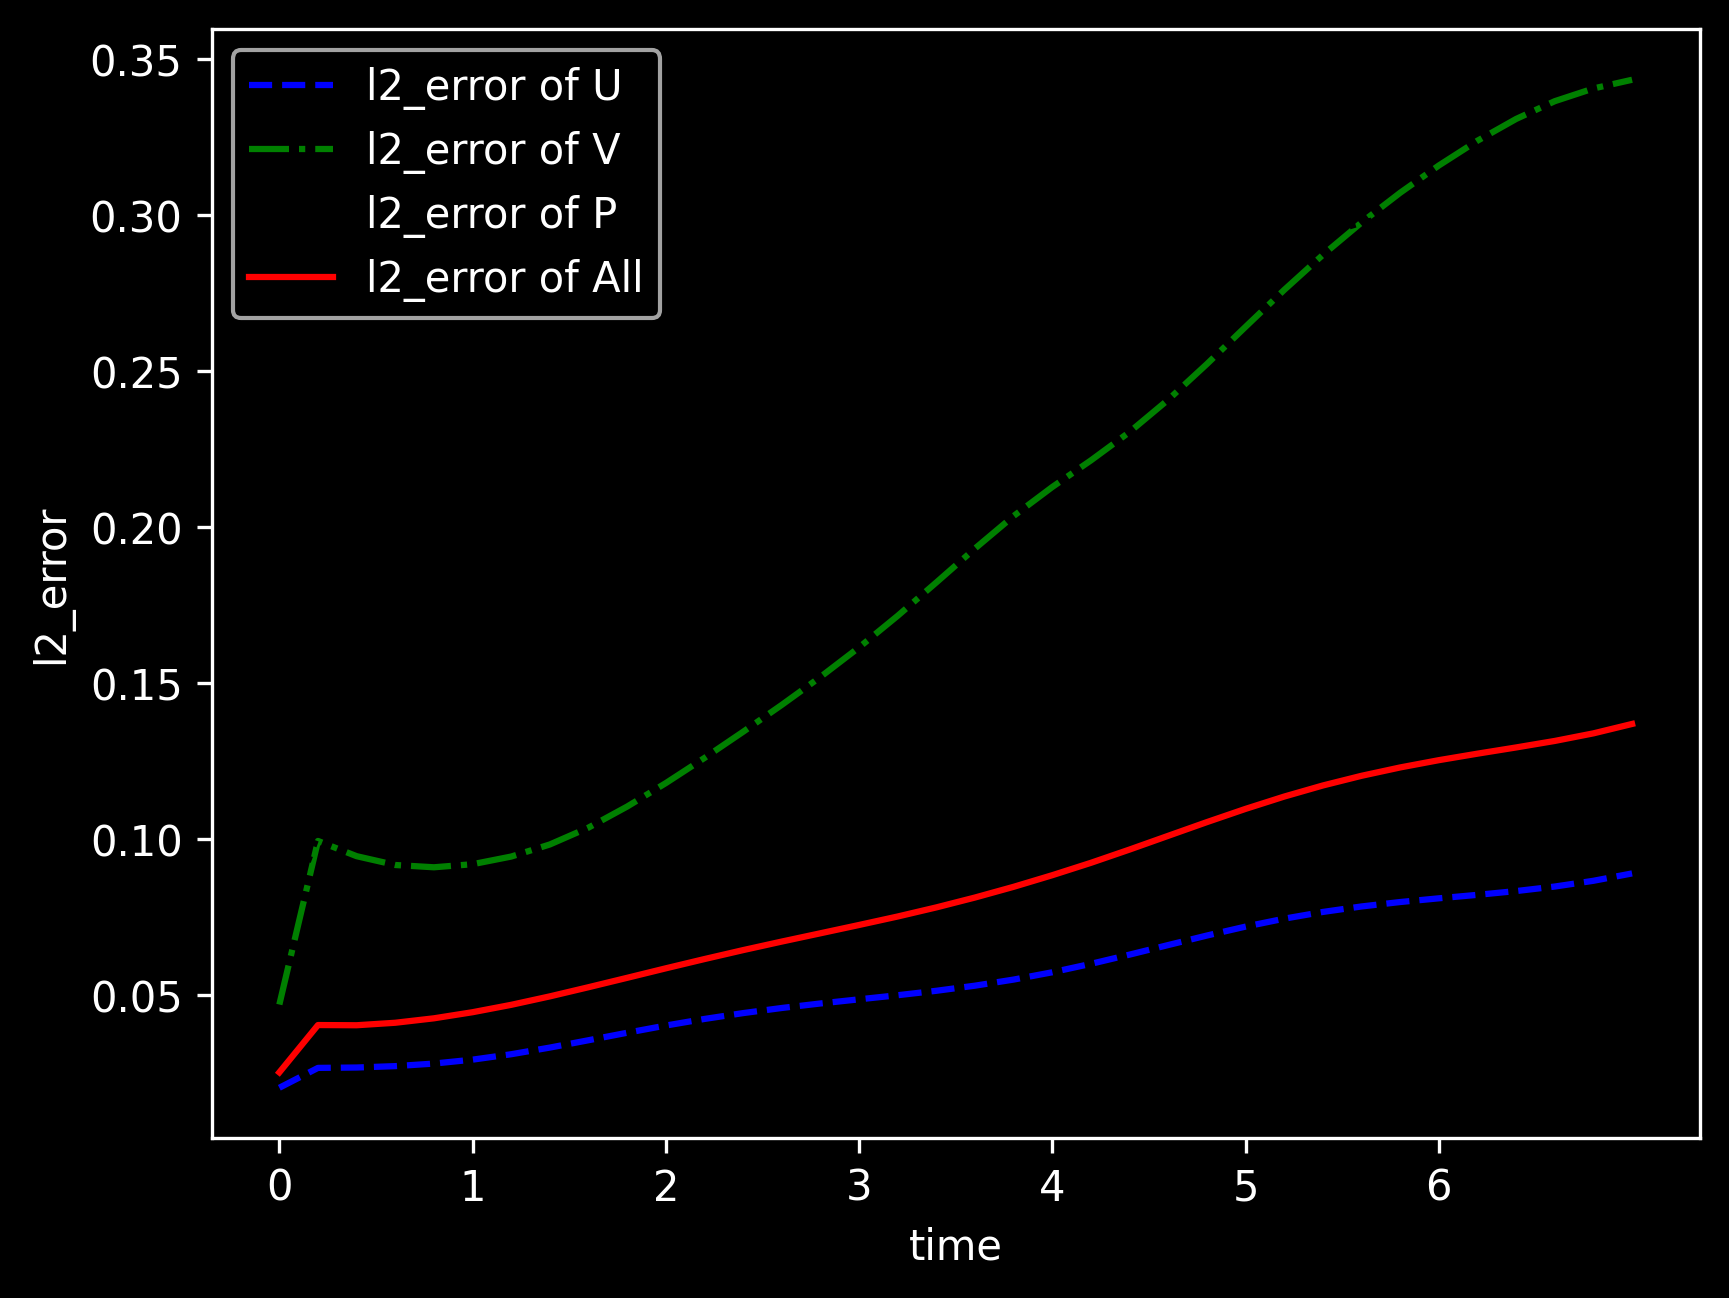

In [11]:
from src import visual

# visualization
visual(model=model, epochs=config["train_epochs"], input_data=inputs, label=label)